In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import colorsys
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

stimrespdecodingfilename = 'D:\\stimdecoding_resp.csv'
stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stimbufferdecodingfilename = 'D:\\stimdecoding_25s_buffer.csv'
stimnobufferdecodingfilename = 'D:\\stimdecoding_25s_nobuffer.csv'
stimnotrimdecodingfilename = 'D:\\stimdecoding_25s_notrim.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Automated Phases

In [31]:
blakeanimals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_16','DS_19']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']#,'DS_16','DS_17','DS_22','DS_13','DS_23']

In [23]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:18: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:18: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:18: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:18: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:18: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:18: RuntimeWarning: inv

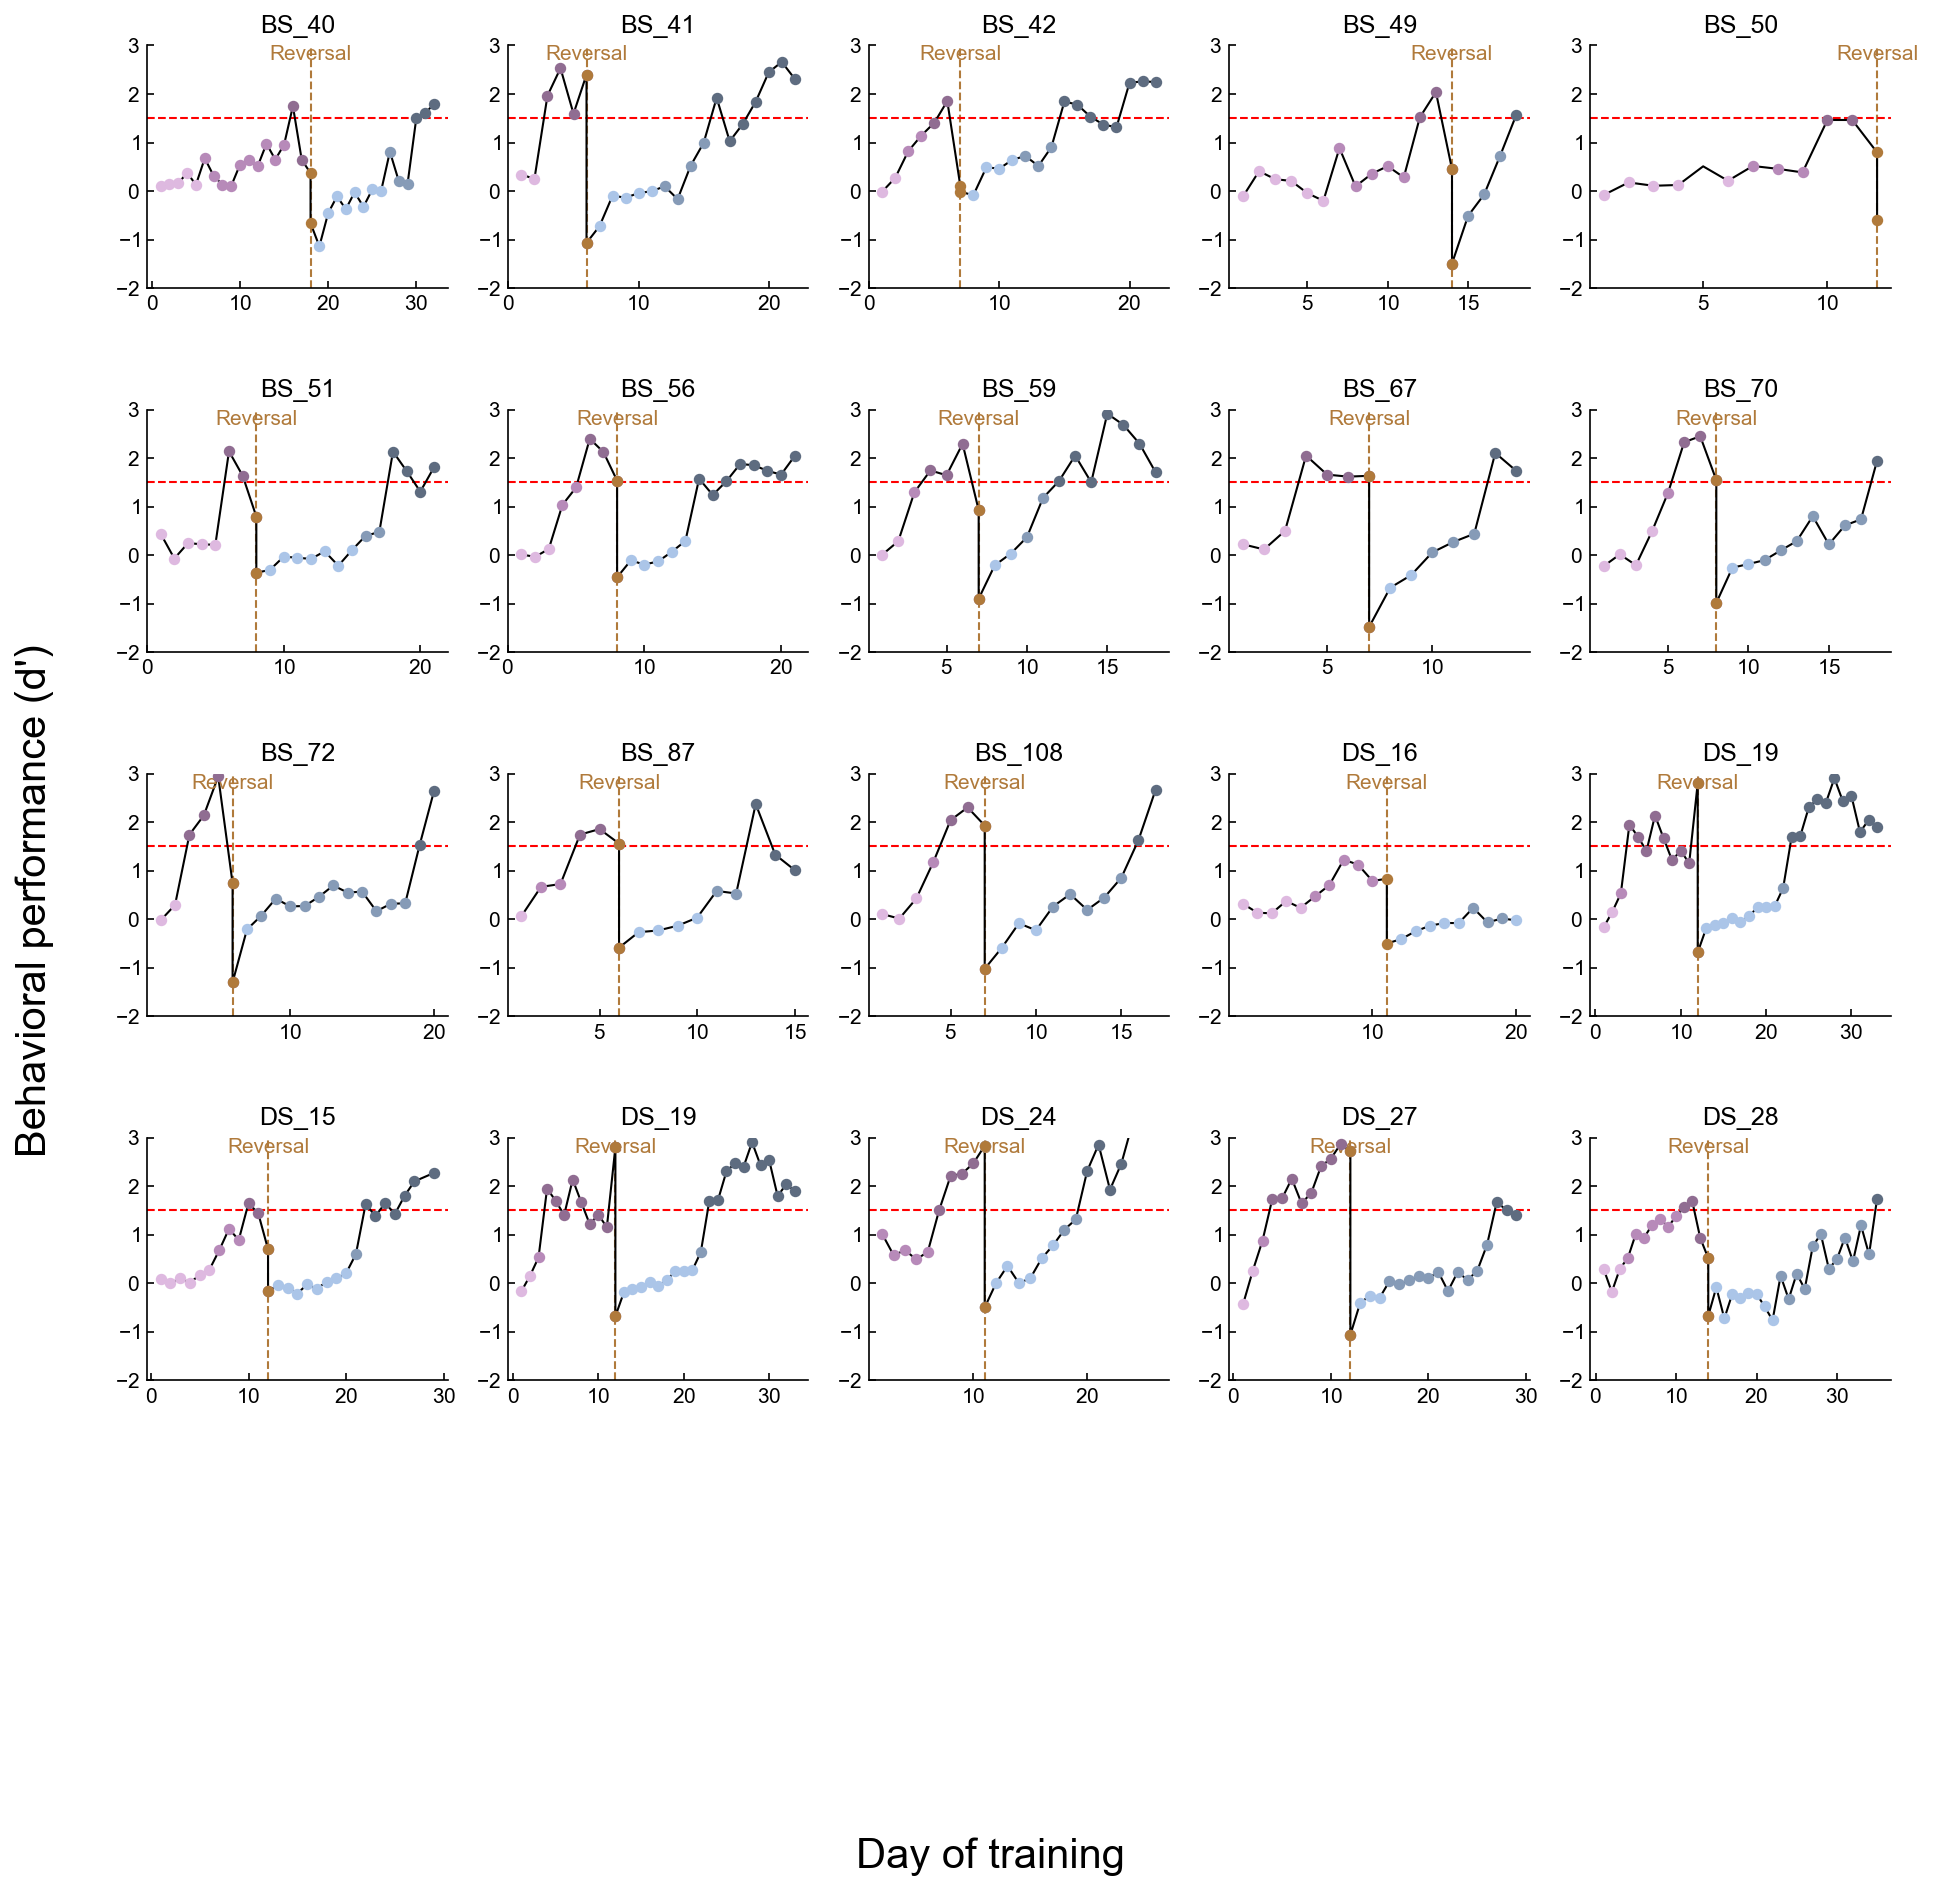

In [24]:
learning_phases,_,_ = ilep.calculateLearningPhases(np.concatenate((blakeanimals,danimals)),animalBehaviors,plot=True)

In [55]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in blakeanimals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 592/592 [00:02<00:00, 218.57it/s]


In [56]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and animal in ['DS_15','DS_19']:
            EILphases[idx] = 'pre expert'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1288/1288 [00:07<00:00, 172.90it/s]

errors for: []


In [57]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

FRb_preearly = []
FRb_prelate = []
FRb_preexpert = []
FRb_postearly = []
FRb_postlate = []
FRb_postexpert = []

FRe_preearly = []
FRe_prelate = []
FRe_preexpert = []
FRe_postearly = []
FRe_postlate = []
FRe_postexpert = []

FReT_preearly = []
FReT_prelate = []
FReT_preexpert = []
FReT_postearly = []
FReT_postlate = []
FReT_postexpert = []

FReNT_preearly = []
FReNT_prelate = []
FReNT_preexpert = []
FReNT_postearly = []
FReNT_postlate = []
FReNT_postexpert = []

FRt_preearly = []
FRt_prelate = []
FRt_preexpert = []
FRt_postearly = []
FRt_postlate = []
FRt_postexpert = []

ramping_preearly = []
ramping_prelate = []
ramping_preexpert = []
ramping_postearly = []
ramping_postlate = []
ramping_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
        
    if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
        continue
        
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
        continue
        
    if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
        continue
        
    if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
        continue
        
    if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
        continue
        
    #if not sessionfile.meta.animal in ['BS_213','BS_214']:
    #    continue
    
    #else:
    #    print(ilep.generateDateString(sessionfile))
    #    print(len(sessionfile.clusters.good))
        
    #if np.isnan(accuracies[idx]):
    #    continue
        
    if EILphases[idx] == 'pre early':
        FRb_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preearly.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_preearly.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #temp = ( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )        
        #Dec_preearly.append(accuracies[idx])
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRb_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_prelate.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_prelate.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )                
        #Dec_preint.append(accuracies[idx])
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRb_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preexpert.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_preexpert.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_preexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_prelate.append(accuracies[idx])
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRb_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postearly.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postearly.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postearly.append(accuracies[idx])
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRb_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postlate.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postlate.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postint.append(accuracies[idx])
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRb_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postexpert.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postexpert.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postlate.append(accuracies[idx])
        postexpert_animals.append(sessionfile.meta.animal)
        
FRb_preearly = np.array(FRb_preearly)
FRb_prelate = np.array(FRb_prelate)
FRb_preexpert = np.array(FRb_preexpert)
FRb_postearly = np.array(FRb_postearly)
FRb_postlate = np.array(FRb_postlate)
FRb_postexpert = np.array(FRb_postexpert)

FRe_preearly = np.array(FRe_preearly)
FRe_prelate = np.array(FRe_prelate)
FRe_preexpert = np.array(FRe_preexpert)
FRe_postearly = np.array(FRe_postearly)
FRe_postlate = np.array(FRe_postlate)
FRe_postexpert = np.array(FRe_postexpert)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

FReT_preearly = np.array(FReT_preearly)
FReT_prelate = np.array(FReT_prelate)
FReT_preexpert = np.array(FReT_preexpert)
FReT_postearly = np.array(FReT_postearly)
FReT_postlate = np.array(FReT_postlate)
FReT_postexpert = np.array(FReT_postexpert)

FReNT_preearly = np.array(FReNT_preearly)
FReNT_prelate = np.array(FReNT_prelate)
FReNT_preexpert = np.array(FReNT_preexpert)
FReNT_postearly = np.array(FReNT_postearly)
FReNT_postlate = np.array(FReNT_postlate)
FReNT_postexpert = np.array(FReNT_postexpert)

ramping_preearly = np.array(ramping_preearly)
ramping_prelate = np.array(ramping_prelate)
ramping_preexpert = np.array(ramping_preexpert)
ramping_postearly = np.array(ramping_postearly)
ramping_postlate = np.array(ramping_postlate)
ramping_postexpert = np.array(ramping_postexpert)
ramping_preearly = ramping_preearly[np.isfinite(ramping_preearly)]
ramping_prelate = ramping_prelate[np.isfinite(ramping_prelate)]
ramping_preexpert = ramping_preexpert[np.isfinite(ramping_preexpert)]
ramping_postearly = ramping_postearly[np.isfinite(ramping_postearly)]
ramping_postlate = ramping_postlate[np.isfinite(ramping_postlate)]
ramping_postexpert = ramping_postexpert[np.isfinite(ramping_postexpert)]

# FRt_preearly = np.array(FRt_preearly)
# FRt_prelate = np.array(FRt_prelate)
# FRt_preexpert = np.array(FRt_preexpert)
# FRt_postearly = np.array(FRt_postearly)
# FRt_postlate = np.array(FRt_postlate)
# FRt_postexpert = np.array(FRt_postexpert)

# Dec_preearly = np.array(Dec_preearly)
# Dec_preint = np.array(Dec_preint)
# Dec_prelate = np.array(Dec_prelate)
# Dec_postearly = np.array(Dec_postearly)
# Dec_postint = np.array(Dec_postint)
# Dec_postlate = np.array(Dec_postlate)

1288it [00:07, 175.90it/s]


In [58]:
stim_resp_df = pd.read_csv(stimrespdecodingfilename)
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
stim_buffer_df = pd.read_csv(stimbufferdecodingfilename)
stim_nobuffer_df = pd.read_csv(stimnobufferdecodingfilename)
stim_notrim_df = pd.read_csv(stimnotrimdecodingfilename)
stim_notrim_df = pd.read_csv(stimnotrimdecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)

dec_df = pd.concat([stim_25s_df,choice_df])
#dec_df.set_index(['session'])#,'clust','categories'])

old_dec_filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-18FromCache.csv' #Old data
#old_dec_filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-20FromCache.csv' #Data not quite used for SfN
old_dec_df = pd.read_csv(old_dec_filename)

In [59]:
def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')
    
#getDataPoint(dec_df,'BS_108_1_AC.pickle',9,'stimulus','accuracy')

In [60]:
FRmod_baseline_median = np.nanmedian(FRmod_preearly)

Dec_preearly = []
Dec_prelate = []
Dec_preexpert = []
Dec_postearly = []
Dec_postlate = []
Dec_postexpert = []

Dec_CR_preearly = []
Dec_CR_prelate = []
Dec_CR_preexpert = []
Dec_CR_postearly = []
Dec_CR_postlate = []
Dec_CR_postexpert = []

Dec_NCR_preearly = []
Dec_NCR_prelate = []
Dec_NCR_preexpert = []
Dec_NCR_postearly = []
Dec_NCR_postlate = []
Dec_NCR_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    acc = getDataPoint(stim_25s_df,session,clust,'stimulus','accuracy')
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    
    if EILphases[idx] == 'pre early':
        Dec_preearly.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_preearly.append(acc)
        else:
            Dec_NCR_preearly.append(acc)
    elif EILphases[idx] == 'pre late':
        Dec_prelate.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_prelate.append(acc)
        else:
            Dec_NCR_prelate.append(acc)
    elif EILphases[idx] == 'pre expert':
        Dec_preexpert.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_preexpert.append(acc)
        else:
            Dec_NCR_preexpert.append(acc)
    elif EILphases[idx] == 'post early':
        Dec_postearly.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_postearly.append(acc)
        else:
            Dec_NCR_postearly.append(acc)
    elif EILphases[idx] == 'post late':
        Dec_postlate.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_postlate.append(acc)
        else:
            Dec_NCR_postlate.append(acc)
    elif EILphases[idx] == 'post expert':
        Dec_postexpert.append(acc)
        if FRmod >= FRmod_baseline_median:
            Dec_CR_postexpert.append(acc)
        else:
            Dec_NCR_postexpert.append(acc)
        
Dec_preearly = np.array(Dec_preearly)
Dec_prelate = np.array(Dec_prelate)
Dec_preexpert = np.array(Dec_preexpert)
Dec_postearly = np.array(Dec_postearly)
Dec_postlate = np.array(Dec_postlate)
Dec_postexpert = np.array(Dec_postexpert)

Dec_CR_preearly = np.array(Dec_CR_preearly)
Dec_CR_prelate = np.array(Dec_CR_prelate)
Dec_CR_preexpert = np.array(Dec_CR_preexpert)
Dec_CR_postearly = np.array(Dec_CR_postearly)
Dec_CR_postlate = np.array(Dec_CR_postlate)
Dec_CR_postexpert = np.array(Dec_CR_postexpert)

Dec_NCR_preearly = np.array(Dec_NCR_preearly)
Dec_NCR_prelate = np.array(Dec_NCR_prelate)
Dec_NCR_preexpert = np.array(Dec_NCR_preexpert)
Dec_NCR_postearly = np.array(Dec_NCR_postearly)
Dec_NCR_postlate = np.array(Dec_NCR_postlate)
Dec_NCR_postexpert = np.array(Dec_NCR_postexpert)

1288it [00:08, 143.22it/s]


baseline = nan
(0.7313725490196079, 0.0, 0.032030914555603224)
(0.7313725490196079, 0.0, 0.032030914555603224)
(0.7313725490196079, 0.0, 0.032030914555603224)
(0.7313725490196079, 0.0, 0.032030914555603224)


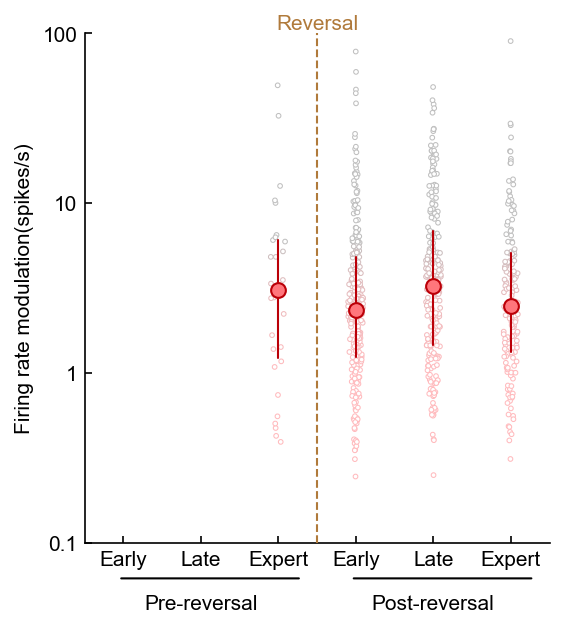

In [43]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = np.median(FRmod_preearly)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
data = [ilep.rmnan(col) for col in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    if len(column) < 10:
        continue
    
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
#
ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.annotate('', xy=(0.07, -0.07), xycoords='axes fraction', xytext=(0.47, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.57, -0.07), xycoords='axes fraction', xytext=(0.97, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

#plt.tight_layout()
#fig.savefig(os.path.join('D:\\\\TempFigures','Firing rate modulation blake animals.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\TempFigures','Firing rate modulation dan animals.pdf'),transparent=False,facecolor="white")

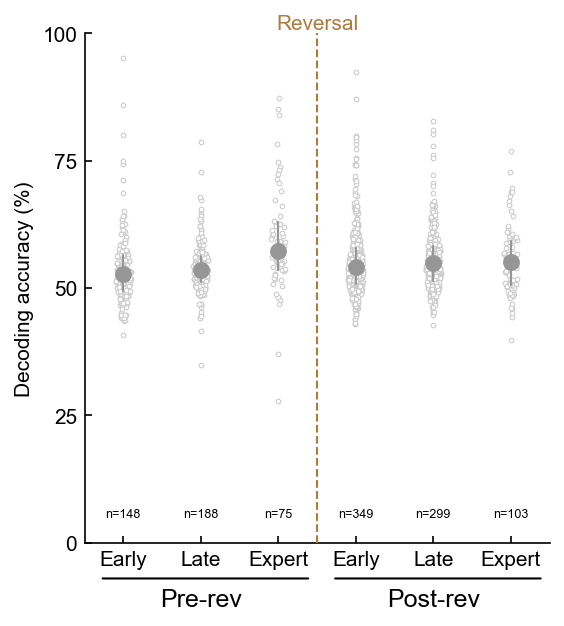

In [61]:
#Firing rate modulation graphs

size=5

#FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
#print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [Dec_preearly,Dec_prelate,Dec_preexpert,Dec_postearly,Dec_postlate,Dec_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):    
    if len(column) < 10:
        continue
        
    eye_color=GOOD_GREY#NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,0.050,f"n={len(FRmod_preearly)}",fontsize=6,horizontalalignment='center')
ax.text(1,0.050,f"n={len(FRmod_prelate)}",fontsize=6,horizontalalignment='center')
ax.text(2,0.050,f"n={len(FRmod_preexpert)}",fontsize=6,horizontalalignment='center')
ax.text(3,0.050,f"n={len(FRmod_postearly)}",fontsize=6,horizontalalignment='center')
ax.text(4,0.050,f"n={len(FRmod_postlate)}",fontsize=6,horizontalalignment='center')
ax.text(5,0.050,f"n={len(FRmod_postexpert)}",fontsize=6,horizontalalignment='center')

#ax.axhline(task_encoder_threshold_s,linestyle='--',lw=1,zorder=-10,color=GOOD_GREY)

#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

fig.savefig(os.path.join('D:\\\\TempFigures','decoding accuracy blake animals.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join('D:\\\\TempFigures','decoding accuracy dan animals.pdf'),transparent=False,facecolor="white")